# Linear Regression Notebook

In [260]:
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression, LassoCV
import statsmodels.api as sm
from sklearn.model_selection import (cross_val_score, train_test_split, GridSearchCV,KFold)
from sklearn.linear_model import lars_path
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

### Step 1: Load Data

In [261]:
df = pd.read_pickle("clean_school_df.pkl")

In [262]:
features, target = ['Asian', 'Average daily attendance', 'Black',
       'English language learners', 'Enrollment',
       'Free or reduced priced lunch', 'Hispanic',
       'How many graduates earn Advanced Regents diplomas?',
       'How many graduates stay enrolled in college for at least 3 semesters?',
       'How many students graduate with test scores high enough to enroll at CUNY without remedial help?',
       'How many students miss 18 or more days of school?',
       'How many students say they feel safe in the hallways, bathrooms and locker rooms?',
       'How many students take a college-level course or earn a professional certificate?',
       'How many students think bullying happens most or all of the time at this school?',
       'How many students were suspended?',
       'How many teachers have 3 or more years of experience teaching?',
       'How many teachers say order and discipline are maintained at this school?',
       'How many teachers say the principal is an effective manager?',
       'How many teachers say they would recommend this school to other families?',
       'Other', 'Students with disabilities', 'Teacher Effectiveness', 'White',
       'Years of principal experience at this school', '$ per Student'],['How many students graduate in 4 years?']

X, y = df[features], df[target]

In [263]:
features_dict = {'Asian':'x1', 'Average daily attendance':'x2', 'Black':'x3',
       'English language learners':'x4', 'Enrollment':'x5',
       'Free or reduced priced lunch':'x6', 'Hispanic':'x7',
       'How many graduates earn Advanced Regents diplomas?':'x8',
       'How many graduates stay enrolled in college for at least 3 semesters?':'x9',
       'How many students graduate with test scores high enough to enroll at CUNY without remedial help?':'x10',
       'How many students miss 18 or more days of school?':'x11',
       'How many students say they feel safe in the hallways, bathrooms and locker rooms?':'x12',
       'How many students take a college-level course or earn a professional certificate?':'x13',
       'How many students think bullying happens most or all of the time at this school?':'x14',
       'How many students were suspended?':'x15',
       'How many teachers have 3 or more years of experience teaching?':'x16',
       'How many teachers say order and discipline are maintained at this school?':'x17',
       'How many teachers say the principal is an effective manager?':'x18',
       'How many teachers say they would recommend this school to other families?':'x19',
       'Other':'x20', 'Students with disabilities':'x21', 'Teacher Effectiveness':'x22', 'White':'x23',
       'Years of principal experience at this school':'x24', '$ per Student':'x25'}

### Step 2: Baseline Model: Use Daily Attendance as a Single Feature

In [264]:
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(df['Average daily attendance'], y, test_size=0.1,random_state=82)

In [265]:
X_train_base = np.array(X_train_base)
lm_base = LinearRegression()
lm_base.fit(X_train_base.reshape(-1, 1),y_train_base)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [266]:
X_test_base = np.array(X_test_base)
linear_score = lm_base.score(X_train_base.reshape(-1,1),y_train_base)
linear_score

0.5116556575479365

In [267]:
y_pred_base = lm_base.predict(X_test_base.reshape(-1,1))
y_pred_base
y_pred_base[y_pred_base > 100] = 100
print("Base:", r2_score(y_test_base, y_pred_base))

Base: 0.573251386776837


In [268]:
(lm_base.coef_[0],lm_base.intercept_[0])

(array([1.71126564]), -71.67987440017654)

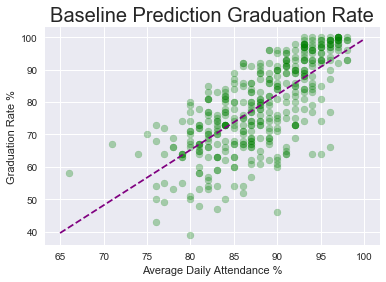

In [327]:
fig = plt.figure()
plt.scatter(df['Average daily attendance'],y,color='g',alpha=.3);
x_vals = np.linspace(65,100,1000)
y_vals = lm_base.intercept_[0] + lm_base.coef_[0][0] * x_vals
plt.plot(x_vals, y_vals, '--',color='purple')
plt.xlabel('Average Daily Attendance %')
plt.ylabel('Graduation Rate %')
plt.title('Baseline Prediction Graduation Rate',size=20);


fig.patch.set_facecolor('white')

### Step 3: Add additional features

Run simple linear regression using all 25 features. Plot residuals to determine if other work is needed.

Split into train and test sets

In [270]:
X, y = df[features], df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=4)

In [271]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

Due to a small sample, run cross validation with different random states and get mean score. 

In [272]:
lin_reg = LinearRegression()
means=[]
coef_list=[]
test_scores=[]
rmses=[]
for i in range(0,100):
    kfold = KFold(n_splits=4, shuffle=True, random_state=i)
    scores = cross_val_score(lin_reg, X_train, y_train, cv=kfold)
    means.append(np.mean(scores))
    
    for k, (train, test) in enumerate(kfold.split(X, y)):
        #print(y.iloc[train])
        lin_reg.fit(X.iloc[train],y.iloc[train])
        coef_list.append(lin_reg.coef_)
        y_pred_linear = lin_reg.predict(X.iloc[test])
        y_pred_linear[y_pred_linear > 100] = 100
        test_scores.append(r2_score(y.iloc[test], y_pred_linear))
        rmses.append(RMSE(y.iloc[test],y_pred_linear))
        
training_means=np.mean(means)
test_means=np.mean(test_scores)
rmse=np.mean(rmses)
coef_lists = [x.tolist() for x in coef_list]
# coef_lists
coefs=map(mean, zip(*coef_lists[0]))
#list(zip(features,coefs))
(training_means,test_means,rmse)

(0.7197801935048763, 0.7250344888723135, 7.039209745076895)

Train model on entire training and test sets, get training score

In [273]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_train_pred = lin_reg.predict(X_train)
y_train_pred[y_train_pred > 100] = 100
train_linear_score = lin_reg.score(X_train,y_train)
print("Linear Training Score: "+ str(train_linear_score))


Linear Training Score: 0.7737187007986142


Get predictions from model, constrain predictions to be a maximum of 100%

In [274]:
y_pred_linear = lin_reg.predict(X_test)
y_pred_linear[y_pred_linear > 100] = 100
print("Linear Test Score:", r2_score(y_test, y_pred_linear))

Linear Test Score: 0.6878503571616368


In [275]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

print(RMSE(y_pred_linear,y_test))

How many students graduate in 4 years?    6.993718
dtype: float64


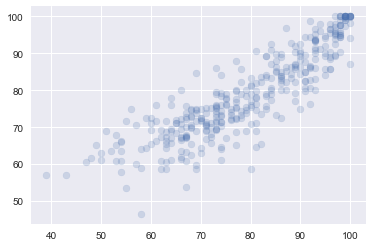

In [276]:
y_train_pred = lin_reg.predict(X_train)
y_train_pred[y_train_pred > 100] = 100
plt.scatter(y_train, y_train_pred, alpha=0.2);

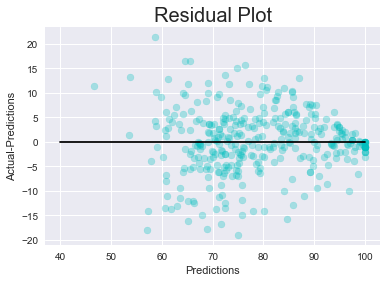

In [278]:
lin_reg_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, lin_reg_residuals, alpha=.3,c='c');
plt.plot([40,100],[0,0], color='k');
plt.title("Residual Plot",size=20);
plt.xlabel('Predictions');
plt.ylabel('Actual-Predictions');


### Step 4: Lasso Regression with Standardization

Use Lasso Regression with standarized features to be able to compare the relative effects of features on predicting graduation rate

Scale features before using Lasso

In [279]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
std2 = StandardScaler()
std2.fit(X_test)
X_te = std2.transform(X_test)

std3 = StandardScaler()
std3.fit(X)
X_tr_whole = pd.DataFrame(std3.transform(X))

Due to a small sample, run cross validation with different random states and get mean score and coefficients.

In [280]:
score_list=[]
test_list=[]
coef_list=[]
rmses_lasso=[]

for i in range(100):
    
    for k, (train, test) in enumerate(kfold.split(X_tr_whole, y)):
        kf = KFold(n_splits=4, shuffle=True, random_state=i)
        lcv = LassoCV(n_alphas=1000,cv=kf)
        lcv.fit(X_tr_whole.iloc[train], np.array(y.iloc[train]).flatten())
        score_list.append(lcv.score(X_tr_whole.iloc[train],y.iloc[train]))
        
        las = Lasso(alpha=lcv.alpha_)
        las.fit(X_tr_whole.iloc[train],y.iloc[train])
        coef_list.append(list(las.coef_))
        y_pred_lasso = las.predict(X_tr_whole.iloc[test])
        y_pred_lasso[y_pred_lasso > 100] = 100
        test_list.append(r2_score(y.iloc[test], y_pred_lasso))
        rmses_lasso.append(RMSE(np.array(y.iloc[test]),y_pred_lasso))

training=np.mean(score_list)
test_scores = np.mean(test_list)
rmse_lasso=np.mean(rmses_lasso)
coefss=map(mean, zip(*coef_list))
#print(list(zip(X_train.columns,coefs)))

print((training,test_scores,rmse_lasso))

(0.7615183886887291, 0.7349680934581508, 17.528651332595842)


### Step 5: Try Combinations of Features

Create polynomial and interaction features to see if adding those helps better predict graduation rate. (Spoiler: they do not.)

In [282]:
interactions = PolynomialFeatures(degree=2,interaction_only=True)

In [283]:
X_interactions = interactions.fit_transform(X_train)
X_inter_test=interactions.fit_transform(X_test)

std = StandardScaler()
std.fit(X_interactions)
X_tr_int = std.transform(X_interactions)

std = StandardScaler()
std.fit(X_inter_test)
X_te_int = std.transform(X_inter_test)

In [284]:
m=LinearRegression()
m.fit(X_interactions,y_train)
train_score=m.score(X_interactions,y_train)
test_score=m.score(X_inter_test,y_test)
train_score,test_score

(0.980095008350741, -10.376596645225744)

In [285]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
lcv = LassoCV(n_alphas=1000,cv=kfold)
lcv.fit(X_tr_int, np.array(y_train).flatten())
train_score=lcv.score(X_tr_int,y_train)
test_score=lcv.score(X_te_int,y_test)
train_score,test_score

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

(0.7880519579279992, 0.6799698725080939)

In [286]:
inters=list(zip(interactions.get_feature_names(),lcv.coef_))
inters.sort(key=lambda tup: abs(tup[1]))
inters

[('1', 0.0),
 ('x0', -0.0),
 ('x2', 0.0),
 ('x3', -0.0),
 ('x4', -0.0),
 ('x5', -0.0),
 ('x6', -0.0),
 ('x7', 0.0),
 ('x8', 0.0),
 ('x9', 0.0),
 ('x10', -0.0),
 ('x11', 0.0),
 ('x12', 0.0),
 ('x13', -0.0),
 ('x14', 0.0),
 ('x16', 0.0),
 ('x17', 0.0),
 ('x18', 0.0),
 ('x19', 0.0),
 ('x20', 0.0),
 ('x21', -0.0),
 ('x22', 0.0),
 ('x23', 0.0),
 ('x24', -0.0),
 ('x0 x1', -0.0),
 ('x0 x2', 0.0),
 ('x0 x4', 0.0),
 ('x0 x5', -0.0),
 ('x0 x6', -0.0),
 ('x0 x7', 0.0),
 ('x0 x8', 0.0),
 ('x0 x9', 0.0),
 ('x0 x10', -0.0),
 ('x0 x11', -0.0),
 ('x0 x12', 0.0),
 ('x0 x13', -0.0),
 ('x0 x14', -0.0),
 ('x0 x15', -0.0),
 ('x0 x16', -0.0),
 ('x0 x17', -0.0),
 ('x0 x18', -0.0),
 ('x0 x19', 0.0),
 ('x0 x20', 0.0),
 ('x0 x21', -0.0),
 ('x0 x22', 0.0),
 ('x0 x23', -0.0),
 ('x0 x24', -0.0),
 ('x1 x2', 0.0),
 ('x1 x3', -0.0),
 ('x1 x4', -0.0),
 ('x1 x5', 0.0),
 ('x1 x6', -0.0),
 ('x1 x7', 0.0),
 ('x1 x10', -0.0),
 ('x1 x12', 0.0),
 ('x1 x13', -0.0),
 ('x1 x14', 0.0),
 ('x1 x15', -0.0),
 ('x1 x16', 0.0),
 ('x1 

### Step 6: Analzye Relevant Features

Using the coefficients from Lasso Linear Regression, I create boxplots of the top 5 features that contribute toward predicting graduation rate

In [287]:
from pandas import DataFrame

coefs=DataFrame.from_records(coef_list)
coefs.columns=X_train.columns

coefs.head()

,Asian,Average daily attendance,Black,English language learners,Enrollment,Free or reduced priced lunch,Hispanic,How many graduates earn Advanced Regents diplomas?,How many graduates stay enrolled in college for at least 3 semesters?,How many students graduate with test scores high enough to enroll at CUNY without remedial help?,...,How many teachers have 3 or more years of experience teaching?,How many teachers say order and discipline are maintained at this school?,How many teachers say the principal is an effective manager?,How many teachers say they would recommend this school to other families?,Other,Students with disabilities,Teacher Effectiveness,White,Years of principal experience at this school,$ per Student
0,-0.286958,3.567372,0.605534,-2.289225,-0.328654,0.198558,-0.0,0.0,2.582150,3.626259,...,-1.479430,0.507164,0.000000,0.439690,0.319587,0.000000,0.576410,-0.000000,0.000000,-0.361205
1,-0.231051,3.782193,0.169089,-2.087511,-0.210617,0.124977,0.0,0.0,3.382458,3.633069,...,-1.459094,-0.000000,0.000000,0.648402,0.303161,0.323927,0.000000,-0.092436,-0.000000,-0.000000
2,-0.762717,8.042371,1.036138,-1.171163,-0.209378,0.980053,-0.0,0.0,2.940662,5.170661,...,-0.957788,0.116111,0.138845,0.555281,0.953216,1.042398,0.186082,0.269623,0.354842,-0.863653
3,-0.213965,2.372461,0.008869,-1.962072,-0.339487,0.000000,-0.0,-0.0,2.927067,3.732610,...,-1.238723,0.000000,0.000000,0.846106,0.519704,0.000000,0.219173,-0.000000,0.000000,-0.065378
4,-0.185431,3.531063,0.563996,-2.250482,-0.291015,0.021789,-0.0,0.0,2.591334,3.594837,...,-1.455258,0.455629,0.000000,0.474968,0.224210,0.000000,0.531442,-0.000000,0.000000,-0.309953


In [193]:
std3 = StandardScaler()
std3.fit(X)
X_tr_whole = pd.DataFrame(std3.transform(X))

coefs_df = pd.DataFrame(std3.inverse_transform(coefs))
coefs_df.columns=X_train.columns
coefs_df.head()

,Asian,Average daily attendance,Black,English language learners,Enrollment,Free or reduced priced lunch,Hispanic,How many graduates earn Advanced Regents diplomas?,How many graduates stay enrolled in college for at least 3 semesters?,How many students graduate with test scores high enough to enroll at CUNY without remedial help?,...,How many teachers have 3 or more years of experience teaching?,How many teachers say order and discipline are maintained at this school?,How many teachers say the principal is an effective manager?,How many teachers say they would recommend this school to other families?,Other,Students with disabilities,Teacher Effectiveness,White,Years of principal experience at this school,$ per Student
0,6.669063,108.193279,46.980724,-27.573441,466.960080,80.806314,45.2325,15.3,111.912960,133.470992,...,51.652487,85.829064,78.682620,88.032168,3.358161,18.892500,3.638468,9.257500,5.91225,21427.050303
1,7.457311,109.405221,36.498550,-23.897000,558.496835,79.748760,45.2325,15.3,126.639059,133.637974,...,51.956922,76.188917,78.682620,91.505313,3.322021,21.264716,2.957500,8.046564,5.91225,22755.995000
2,-0.038875,133.439548,57.322649,-7.195629,559.457302,92.038532,45.2325,15.3,118.509773,171.339780,...,59.461616,78.395949,81.201697,89.955702,4.752285,26.526308,3.177337,12.789626,7.39851,19578.442365
3,7.698216,101.452036,32.650509,-21.610743,458.559483,77.952500,45.2325,15.3,118.259615,136.078708,...,55.255937,76.188917,78.682620,94.795274,3.798464,18.892500,3.216430,9.257500,5.91225,22515.456703
4,8.100527,107.988439,45.983107,-26.867317,496.148617,78.265663,45.2325,15.3,112.081954,132.700521,...,52.014342,84.849483,78.682620,88.619220,3.148312,18.892500,3.585343,9.257500,5.91225,21615.617207


In [288]:
feature_stds = coefs.std(axis=0)
features = pd.DataFrame(coefs.mean(axis=0))

In [289]:
features['std']=feature_stds
features=features.rename(columns={0: "mean"})
features=features.reindex(features['mean'].abs().sort_values(ascending=False).index)
df_feats=features.head(5)
top5=df_feats.index
top5

Index(['How many students graduate with test scores high enough to enroll at CUNY without remedial help?',
       'Average daily attendance',
       'How many graduates stay enrolled in college for at least 3 semesters?',
       'English language learners',
       'How many students take a college-level course or earn a professional certificate?'],
      dtype='object')

In [294]:
tops=list(top5.values)
coef2=coefs[tops]
coef2['English language learners']=abs(coef2['English language learners'])

coef2.loc[coef2['Average daily attendance'] > 6, 'Average daily attendance'] = np.nan


coef2.columns=['How many students graduate with test scores high enough to enroll at CUNY without remedial help? (+)',
       'Average daily attendance (+)',
       'How many graduates stay enrolled in college for at least 3 semesters? (+)',
       'English language learners (-)',
       'How many students take a college-level course or earn a professional certificate? (+)']

box_data=pd.melt(coef2)
equiv = {'How many students graduate with test scores high enough to enroll at CUNY without remedial help? (+)':0.5,
             'Average daily attendance (+)':1,
             'How many graduates stay enrolled in college for at least 3 semesters? (+)':1.5,
             'English language learners (-)':2,
             'How many students take a college-level course or earn a professional certificate? (+)':2.5}
box_data['pos'] = box_data['variable'].map(equiv)
box_data.sample(15)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,variable,value,pos
231,How many students graduate with test scores hi...,4.068404,0.5
1891,How many students take a college-level course ...,1.610777,2.5
832,How many graduates stay enrolled in college fo...,2.569197,1.5
1521,English language learners (-),2.135155,2.0
398,How many students graduate with test scores hi...,4.590699,0.5
427,Average daily attendance (+),2.542084,1.0
605,Average daily attendance (+),3.645202,1.0
589,Average daily attendance (+),3.908089,1.0
336,How many students graduate with test scores hi...,3.680762,0.5
521,Average daily attendance (+),3.738915,1.0


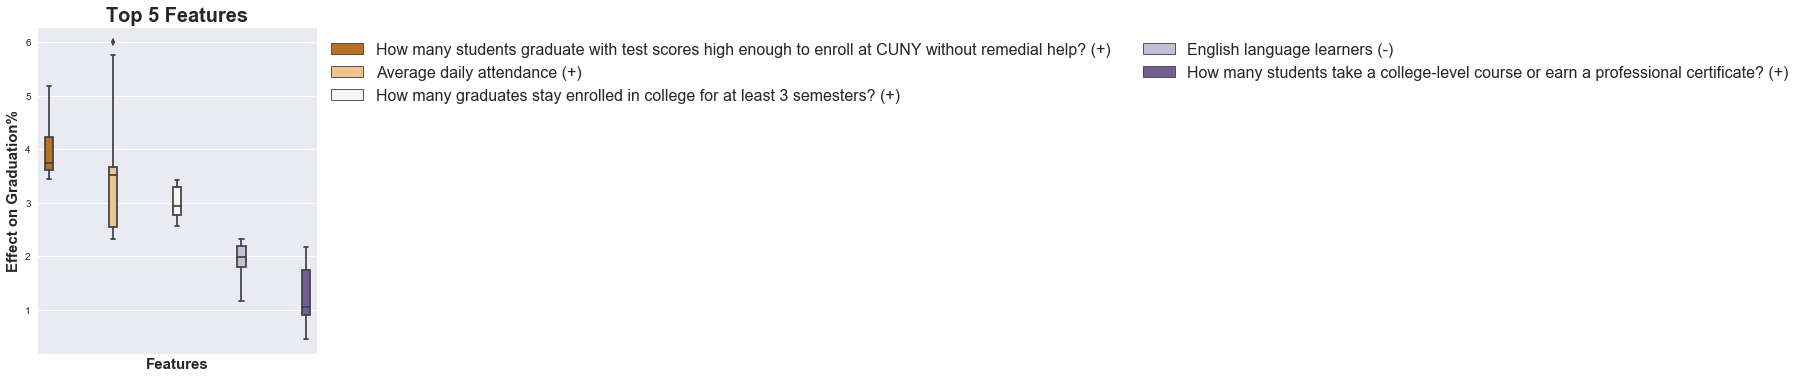

In [320]:
plt.figure(figsize=(5,6))

sns.boxplot(y='value', x='variable', data=box_data, width=.75,palette="PuOr",whis=2, hue='variable')

#plt.boxplot(box_data)
                
plt.title('Top 5 Features',fontsize = 20,loc='center',weight = 'bold');
plt.xlabel('Features',fontsize = 15, weight = 'bold');
plt.ylabel('Effect on Graduation%',fontsize = 15, weight = 'bold');
plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)

plt.legend(prop={'size': 16},bbox_to_anchor=(1, 1),ncol=2);



In [224]:
features.head(8)

,mean,std
How many students graduate with test scores high enough to enroll at CUNY without remedial help?,4.013841,0.538525
Average daily attendance,3.738084,1.393810
How many graduates stay enrolled in college for at least 3 semesters?,2.979459,0.301189
English language learners,-1.926041,0.301221
How many students take a college-level course or earn a professional certificate?,1.282698,0.490938
How many teachers have 3 or more years of experience teaching?,-1.241945,0.258114
How many teachers say they would recommend this school to other families?,0.665536,0.151169
How many students think bullying happens most or all of the time at this school?,-0.626125,0.305359


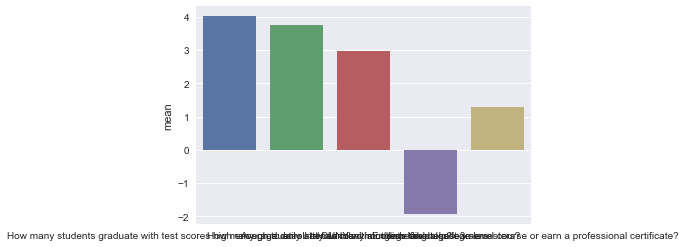

In [232]:
sns.barplot(x=df_feats.index,y=df_feats['mean'],ci=features['std'])